<a href="https://colab.research.google.com/github/LenaGeller/retail_demand_analysis/blob/Notebooks/Best_EDA_and_Feature_Engineering_Perishable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please note: This notebook uses relative paths (e. g. "Data/produce2015-2017_prepared.csv"). To run it in Google Colab, please clone the repository or replace the path with the GitHub RAW link.

# Data Overview

In [ ]:
import pandas as pd, numpy as np, joblib
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from google.colab import drive
import matplotlib.pyplot as plt

df_train = pd.read_csv("Data/produce2015-2017_prepared.csv")
print("DataFrame reloaded, ready to go!")


DataFrame reloaded, ready to go!


In [ ]:
df_train = df_train.drop(columns=["transactions"])

In [ ]:
df_train.head()

,Unnamed: 0,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,city,type,cluster,some_holiday,is_bridge,is_transfer,is_work_day,is_holiday,class
0,0,2015-06-01,47899618,1,1473474,107.636,False,2015,6,1,0,Quito,D,13,False,False,False,False,False,2014
1,1,2015-06-02,47980434,1,1473474,93.536,False,2015,6,2,1,Quito,D,13,False,False,False,False,False,2014
2,2,2015-06-03,48060600,1,1473474,224.225,True,2015,6,3,2,Quito,D,13,False,False,False,False,False,2014
3,3,2015-06-04,48139479,1,1473474,111.914,False,2015,6,4,3,Quito,D,13,False,False,False,False,False,2014
4,4,2015-06-05,48216664,1,1473474,134.079,False,2015,6,5,4,Quito,D,13,False,False,False,False,False,2014


In [ ]:
df = df_train
print("Shape:", df.shape)
print(df.dtypes)


Shape: (77841, 19)
date            datetime64[ns]
id                       int64
store_nbr                int64
item_nbr                 int64
unit_sales             float64
onpromotion               bool
year                     int32
month                    int32
day                      int32
day_of_week              int32
city                    object
type                    object
cluster                  int64
some_holiday              bool
is_bridge                 bool
is_transfer               bool
is_work_day               bool
is_holiday                bool
class                    int64
dtype: object


## EDA 2

Top 10 Items:
 item_nbr
1503844    4066013.636
1473474    3215550.628
1695835    1670230.467
Name: unit_sales, dtype: float64


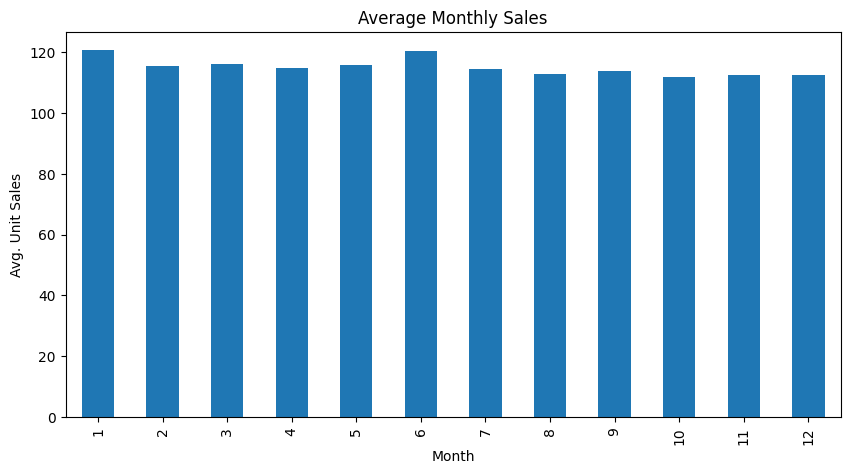

Avg. sales with/without promotion:
 onpromotion
False    108.21257
True     157.68547
Name: unit_sales, dtype: float64


In [ ]:
top_items = (
    df.groupby("item_nbr")["unit_sales"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 Items:\n", top_items)

df["date"] = pd.to_datetime(df["date"])


seasonality = (
    df.groupby(df["date"].dt.month)["unit_sales"]
      .mean()
)

seasonality.plot(kind="bar", figsize=(10,5))
plt.title("Average Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Avg. Unit Sales")
plt.show()

promo_effect = df.groupby("onpromotion")["unit_sales"].mean()
print("Avg. sales with/without promotion:\n", promo_effect)


# Feature Engineering





Here we create rolling features (lags, moving averages, EWMs) and promotion-related features (days since last sale/promo) to capture demand patterns.

In [ ]:
df = df.sort_values(["store_nbr", "item_nbr", "date"]).reset_index(drop=True)

group_cols = ["store_nbr", "item_nbr"]
y = "unit_sales"

for lag in [1, 7, 14, 28]:
    df[f"lag_{lag}"] = (
        df.groupby(group_cols)[y].transform(lambda s: s.shift(lag))
    )

for w in [7, 14, 28]:
    df[f"roll_mean_{w}"] = (
        df.groupby(group_cols)[y].transform(lambda s: s.shift(1).rolling(w).mean())
    )
    df[f"roll_std_{w}"] = (
        df.groupby(group_cols)[y].transform(lambda s: s.shift(1).rolling(w).std())
    )

for span in [7, 28]:
    df[f"ewm_{span}"] = (
        df.groupby(group_cols)[y].transform(lambda s: s.shift(1).ewm(span=span).mean())
    )

import numpy as np

def days_since_last_true(b: pd.Series) -> pd.Series:
    """
    b: bool-Serien (True = Ereignis heute)
    Ergebnis: 0 am Ereignistag, 1 am Folgetag, ...; indextreu.
    """
    n = len(b)
    idx = np.arange(n)
    last_true_pos = np.maximum.accumulate(np.where(b.to_numpy(), idx, -1))
    return pd.Series(idx - last_true_pos, index=b.index)

df["days_since_sale"] = (
    df.groupby(group_cols, group_keys=False)[y]
      .apply(lambda s: days_since_last_true(s.gt(0)))
)

df["days_since_promo"] = (
    df.groupby(group_cols, group_keys=False)["onpromotion"]
      .apply(lambda s: days_since_last_true(s.fillna(False).astype(bool)))
)


In [ ]:
df.dtypes


,0
date,datetime64[ns]
id,int64
store_nbr,int64
item_nbr,int64
unit_sales,float64
onpromotion,bool
year,int32
month,int32
day,int32
day_of_week,int32


Here we add calendar features (month/quarter markers, special month days), holiday proximity features, and promotion-based aggregations to capture seasonality and event effects.

In [ ]:
import numpy as np
import pandas as pd

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["store_nbr", "item_nbr", "date"])

dt = df["date"]
df["weekofyear"]    = dt.dt.isocalendar().week.astype("int16")
df["quarter"]       = dt.dt.quarter.astype("int8")
df["is_month_end"]  = dt.dt.is_month_end.astype(bool)
df["is_month_start"]= dt.dt.is_month_start.astype(bool)

for d in [5, 10, 15, 20, 25, 30]:
    df[f"day_is_{d}"] = (dt.dt.day == d)

any_holiday = (df["is_holiday"])

def _days_since_true(s: pd.Series) -> pd.Series:
    n = len(s); idx = np.arange(n)
    last_pos = np.maximum.accumulate(np.where(s.to_numpy(), idx, -1))
    return pd.Series(idx - last_pos, index=s.index)

def _days_to_next_true(s: pd.Series) -> pd.Series:
    rev = s.iloc[::-1]
    nxt = _days_since_true(rev)
    return nxt.iloc[::-1]

tmp = any_holiday.groupby(df["date"])
date_to_since = _days_since_true(tmp.transform("max"))
date_to_next  = _days_to_next_true(tmp.transform("max"))

df["days_since_holiday"] = date_to_since
df["days_to_next_holiday"] = date_to_next
df['first_open_after_holiday'] = (df['days_since_holiday'] == 1)
df["second_day_after_holiday"] = (df["days_since_holiday"] == 2)
df["third_day_after_holiday"] = (df["days_since_holiday"] == 3)
df["near_holiday_3"] = (df[["days_since_holiday","days_to_next_holiday"]].min(axis=1) <= 3)
df["near_holiday_7"] = (df[["days_since_holiday","days_to_next_holiday"]].min(axis=1) <= 7)


for w in [7, 14]:
    df[f"promo_rollsum_{w}"] = (
        df.groupby(["store_nbr","item_nbr"])["onpromotion"]
            .transform(lambda s: s.shift(1).rolling(w).sum())
            .astype("float32")
    )

df["is_weekend"] = (dt.dt.dayofweek >= 5)
df["promo_x_weekend"] = (df["onpromotion"] & df["is_weekend"])

print(df.filter(regex="weekofyear|quarter|is_month_|day_is_|holiday|promo_").head())


   some_holiday  is_holiday  weekofyear  quarter  is_month_end  \
0         False       False          23        2         False   
1         False       False          23        2         False   
2         False       False          23        2         False   
3         False       False          23        2         False   
4         False       False          23        2         False   

   is_month_start  day_is_5  day_is_10  day_is_15  day_is_20  ...  \
0            True     False      False      False      False  ...   
1           False     False      False      False      False  ...   
2           False     False      False      False      False  ...   
3           False     False      False      False      False  ...   
4           False      True      False      False      False  ...   

   days_since_holiday  days_to_next_holiday  first_open_after_holiday  \
0                   1                    16                      True   
1                   2                    1

In [ ]:
for col in ["city",  "type", "cluster"]:
    df[col] = df[col].astype("category")


Baseline-Sales/Item

In [ ]:
df["item_avg_sales"] = (
    df.groupby("item_nbr")["unit_sales"]
      .transform("mean")
      .astype("float32")
)


print(df[["date", "item_nbr", "unit_sales", "item_avg_sales"]].head(10))



        date  item_nbr  unit_sales  item_avg_sales
0 2015-06-01   1473474     107.636       97.885864
1 2015-06-02   1473474      93.536       97.885864
2 2015-06-03   1473474     224.225       97.885864
3 2015-06-04   1473474     111.914       97.885864
4 2015-06-05   1473474     134.079       97.885864
5 2015-06-06   1473474     133.312       97.885864
6 2015-06-07   1473474      51.073       97.885864
7 2015-06-08   1473474     143.291       97.885864
8 2015-06-09   1473474     106.609       97.885864
9 2015-06-10   1473474     176.000       97.885864


Season Features

In [ ]:
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77841 entries, 0 to 77840
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      77841 non-null  datetime64[ns]
 1   id                        77841 non-null  int64         
 2   store_nbr                 77841 non-null  int64         
 3   item_nbr                  77841 non-null  int64         
 4   unit_sales                77841 non-null  float64       
 5   onpromotion               77841 non-null  bool          
 6   year                      77841 non-null  int32         
 7   month                     77841 non-null  int32         
 8   day                       77841 non-null  int32         
 9   day_of_week               77841 non-null  int32         
 10  city                      77841 non-null  category      
 11  type                      77841 non-null  category      
 12  cluster           

### Holidays vs Workdays

Here we research some holyday-patterns.

In [ ]:
import pandas as pd
import requests
import io

def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))

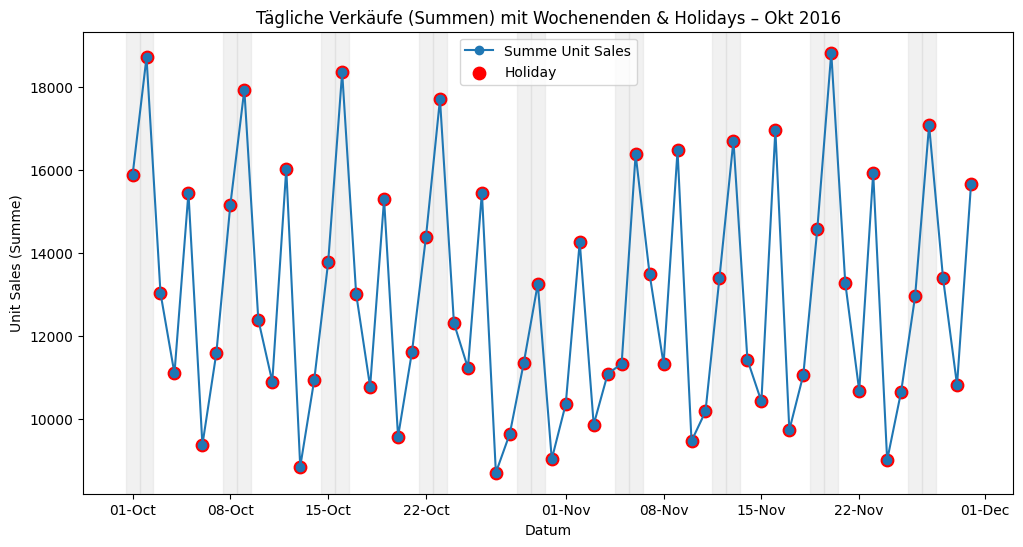

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

month_data = df[(df["date"] >= "2016-10-01") &
                     (df["date"] <= "2016-11-30")]

daily_sales = month_data.groupby("date")["unit_sales"].sum().reset_index()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(daily_sales["date"], daily_sales["unit_sales"], marker="o", label="Summe Unit Sales")

for d in daily_sales["date"]:
    dow = d.dayofweek
    if dow in [5,6]:
        ax.axvspan(d - pd.Timedelta(0.5, "D"), d + pd.Timedelta(0.5, "D"),
                   color="lightgrey", alpha=0.3)

holiday_dates = month_data.loc[month_data["is_holiday"], "date"].unique()
ax.scatter(holiday_dates,
           daily_sales.loc[daily_sales["date"].isin(holiday_dates), "unit_sales"],
           color="red", s=80, label="Holiday")

ax.set_title("Tägliche Verkäufe (Summen) mit Wochenenden & Holidays – Okt 2016")
ax.set_xlabel("Datum")
ax.set_ylabel("Unit Sales (Summe)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.legend()

plt.show()



In [ ]:
df.isnull().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
...,...
promo_dow_2,0
promo_dow_3,0
promo_dow_4,0
promo_dow_5,0


In [ ]:
print("Shape:", df.shape)
print(df.info(memory_usage="deep"))
print(df.head(3).T)


Shape: (77841, 74)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77841 entries, 0 to 77840
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      77841 non-null  datetime64[ns]
 1   id                        77841 non-null  int64         
 2   store_nbr                 77841 non-null  int64         
 3   item_nbr                  77841 non-null  int64         
 4   unit_sales                77841 non-null  float64       
 5   onpromotion               77841 non-null  bool          
 6   year                      77841 non-null  int32         
 7   month                     77841 non-null  int32         
 8   day                       77841 non-null  int32         
 9   day_of_week               77841 non-null  int32         
 10  city                      77841 non-null  category      
 11  type                      77841 non-null  category      
 12 

## NaN-Values

Save the forecast set (with NaNs)

In [ ]:
#df.to_parquet("/content/drive/MyDrive/Time Series/produce2015-2017_forecast_ohnerank1.parquet", compression="zstd", engine="pyarrow")

NaN handling for the train set

In [ ]:
df.isna().sum().sort_values(ascending=False)

nan_positions = df[df["lag_28"].isna()].groupby("item_nbr")["date"].min()
print(nan_positions.head(10))


item_nbr
1473474   2015-06-01
1503844   2015-06-01
1695835   2015-06-01
Name: date, dtype: datetime64[ns]


In [ ]:
df.isna().sum().sort_values(ascending=False)

,0
roll_mean_28,3567
lag_28,3567
roll_std_28,3567
lag_14,1792
roll_std_14,1792
...,...
promo_dow_2,0
promo_dow_3,0
promo_dow_4,0
promo_dow_5,0


We drop the first 28 days to remove most NaN values from lag/rolling features and save the train set.

In [ ]:
feature_cols = [
    "lag_1","lag_7","lag_14","lag_28",
    "roll_mean_7","roll_std_7",
    "roll_mean_14","roll_std_14",
    "roll_mean_28","roll_std_28",
    "ewm_7","ewm_28",
    "promo_rollsum_7","promo_rollsum_14"
]

df_train = df.copy()

min_valid_date = df_train["date"].min() + pd.Timedelta(days=28)
df_train = df_train[df_train["date"] >= min_valid_date].copy()

df_train[feature_cols] = df_train[feature_cols].fillna(0)

#df_train.to_parquet(
    #"/content/drive/MyDrive/Time Series/produce_2015_2017_train_ohnerank1.parquet",
    #compression="zstd", engine="pyarrow"
)

# Kontrolle
print("Forecast shape:", df.shape)
print("Train shape:", df_train.shape)
print("→ Restliche NaNs in Train:", df_train[feature_cols].isna().sum().sum())


Forecast shape: (77841, 74)
Train shape: (74897, 74)
→ Restliche NaNs in Train: 0


In [ ]:
diff_rows = df.shape[0] - df_train.shape[0]
print(f"→ Entfernte Zeilen durch dropna(): {diff_rows}")

→ Entfernte Zeilen durch dropna(): 2944
